In [1]:
source("Main.R")
source("Conf.R")
source("Utilities.R")
source("DAVID_query.R")
library("factoextra")
library("maptree")
library("ggpubr")
library("ica")
#library(ICtest)

library(repr)
fileDir = "/home/beraslan/jovian-work/analysisSingle/"
geneCutOff=4
targetCutOff=15
nFactors=15

corrplot 0.92 loaded


Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:stats’:

    loadings



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: cluster

Loading required package: rpart


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
selCoefs <- read.csv("./../SignificantCoefMatrix.csv", row.names = 1)
selCoefs <- t(selCoefs)
KOGenes <-  colnames(selCoefs)
KOGenes <- sapply(KOGenes, function(x){strsplit(x,"_")[[1]][2]})
colnames(selCoefs) <- KOGenes

In [3]:
head(selCoefs)

,Rack1,Utp15,Wdr43,Raf1,Rrp9,Uhrf1,Myc,Wdr3,Aamp,Dcaf13,⋯,Acaca,Trim45,Rnf135,Dcaf10,Traf7,Zmiz2,Klhl30,Wdr91,Efcab8,Wdr81
Eef1a1,-0.052,-0.147,-0.238,-0.125,-0.135,0.063,-0.397,0.028,-0.052,-0.101,⋯,0.158,-0.042,0.004,0.038,0.025,-0.066,-0.016,0.061,-0.033,0.085
Tpt1,-0.255,-0.096,-0.261,-0.026,-0.079,-0.218,-0.158,-0.159,-0.323,-0.190,⋯,0.104,0.112,0.068,0.024,0.099,0.095,0.119,0.104,0.119,0.050
Rps27,-0.289,-0.235,-0.094,-0.097,-0.104,-0.116,-0.167,-0.087,-0.081,-0.159,⋯,0.075,0.087,0.070,-0.003,0.061,0.024,0.060,0.028,0.077,0.035
Rplp0,-0.328,-0.076,-0.110,-0.130,-0.008,-0.134,-0.586,-0.017,-0.031,-0.064,⋯,0.113,0.017,-0.018,0.145,0.103,0.105,0.017,0.015,0.082,0.047
Denr,-0.140,-0.042,-0.027,-0.047,-0.070,-0.208,-0.079,-0.098,0.140,-0.104,⋯,0.086,0.103,-0.057,-0.118,0.049,0.149,0.198,0.042,0.070,0.017
Hmgb2,-0.078,0.024,-0.019,-0.001,-0.032,-0.083,-0.089,0.054,0.011,-0.039,⋯,0.029,-0.011,0.013,-0.003,0.018,0.045,0.183,0.007,0.124,0.020


In [4]:
#geneModulesN <- data.frame(read.csv("/home/beraslan/jovian-work/analysisSingle/ME_GeneModules_6_Modules.csv", row.names = 1))
geneModulesN <- data.frame(read.csv("./../ME_GeneModules_leiden_8_Modules.csv"), row.names = 1)
rownames(geneModulesN) <- geneModulesN$GeneName
geneModulesN$GeneName <- NULL
geneModulesN$GeneGroup <- factor(geneModulesN$GeneGroup)

head(geneModulesN)

,GeneGroup,GeneColor
,<fct>,<chr>
AI314180,3,#E7298A
Abcc1,3,#E7298A
Acod1,3,#E7298A
Akr1a1,3,#E7298A
Alas1,3,#E7298A
Alox5ap,3,#E7298A


In [22]:
#guideModulesN <- data.frame(read.csv("/home/beraslan/jovian-work/analysisSingle/ME_GuideModules_7_Modules.csv", row.names = 1))
#guideModulesN$GuideName <- sapply(guideModulesN$GuideName, function(x){strsplit(as.character(x),"_")[[1]][2]})

guideModulesN <- data.frame(read.csv("./../ME_GuideModules_leiden_6_Modules.csv"),  row.names = 1)
rownames(guideModulesN) <- guideModulesN$GuideName 

head(guideModulesN)

,GuideName,GuideGroup,GuideColor
,<chr>,<int>,<chr>
Aamp,Aamp,4,#aa40fc
Bop1,Bop1,4,#aa40fc
Cirh1a,Cirh1a,4,#aa40fc
Dcaf13,Dcaf13,4,#aa40fc
Grb2,Grb2,4,#aa40fc
Myc,Myc,4,#aa40fc


In [24]:
## This is for selecting training and validation sets in combo prediction
# allTestGuides = list()

# for(elem in unique(guideModulesN$GuideGroup)){
#     myTmp = guideModulesN[guideModulesN$GuideGroup == elem,]
#     k = sample(myTmp$GuideName, round(nrow(myTmp) *0.10, digits = 0), replace=FALSE)
#     allTestGuides = lappend(allTestGuides, k)
# }

# allTestGuides = unique(unlist(allTestGuides))
# allTrainingGuides = guideModulesN$GuideName[guideModulesN$GuideName %ni% allTestGuides]
# write.csv(allTestGuides, "./../TestGuides.csv")
# write.csv(allTrainingGuides, "./../TrainingGuides.csv")

In [6]:
evaluateFactorNo <- function(){
    allTestGuides = list()

    for(elem in unique(guideModulesN$GuideGroup)){
        myTmp = guideModulesN[guideModulesN$GuideGroup == elem,]
        k = sample(myTmp$GuideName, round(nrow(myTmp) *0.2, digits = 0), replace=FALSE)
        allTestGuides = lappend(allTestGuides, k)
    }

    allTestGuides = unique(unlist(allTestGuides))
    allTrainingGuides = guideModulesN$GuideName[guideModulesN$GuideName %ni% allTestGuides]
    selCoefsTest = data.frame(selCoefs[,allTestGuides])
    selCoefsTrain = data.frame(selCoefs[,allTrainingGuides])
    
    
    allExpVars = list()

    for(i in 1:30){
        k <- icaimax(selCoefsTrain, nc = i, center = T)
        mySelFac = data.frame(k$S)
        
        r2ForNfac= c()
        for(j in 1:ncol(selCoefsTest)){

            mySelFac$y = selCoefsTest[,j]
            k = lm("y ~ .", data= mySelFac)
            myPredict = predict(k, newdata = mySelFac)

            myR2 = computeR2(mySelFac$y, myPredict)
            r2ForNfac = c(r2ForNfac, myR2)
        }
        
        allExpVars = lappend(allExpVars, r2ForNfac)
    }
    
    
    allExpVars = data.frame(do.call(cbind, allExpVars))
    rownames(allExpVars) = colnames(selCoefsTest) 
    colnames(allExpVars) = paste0("NFac_",1:ncol(allExpVars))
    allExpVars$genes = rownames(allExpVars)
    allExpVarsMelted = melt(allExpVars)
    
    return(allExpVarsMelted)

}

In [7]:
hh <- evaluateFactorNo() 

for(i in 1:5){
    vv = evaluateFactorNo()
    
    hh = rbind(hh,  vv)
}


Using genes as id variables

Using genes as id variables

Using genes as id variables

Using genes as id variables

Using genes as id variables

Using genes as id variables



Warning message:
“Removed 1361 rows containing missing values (geom_violin).”


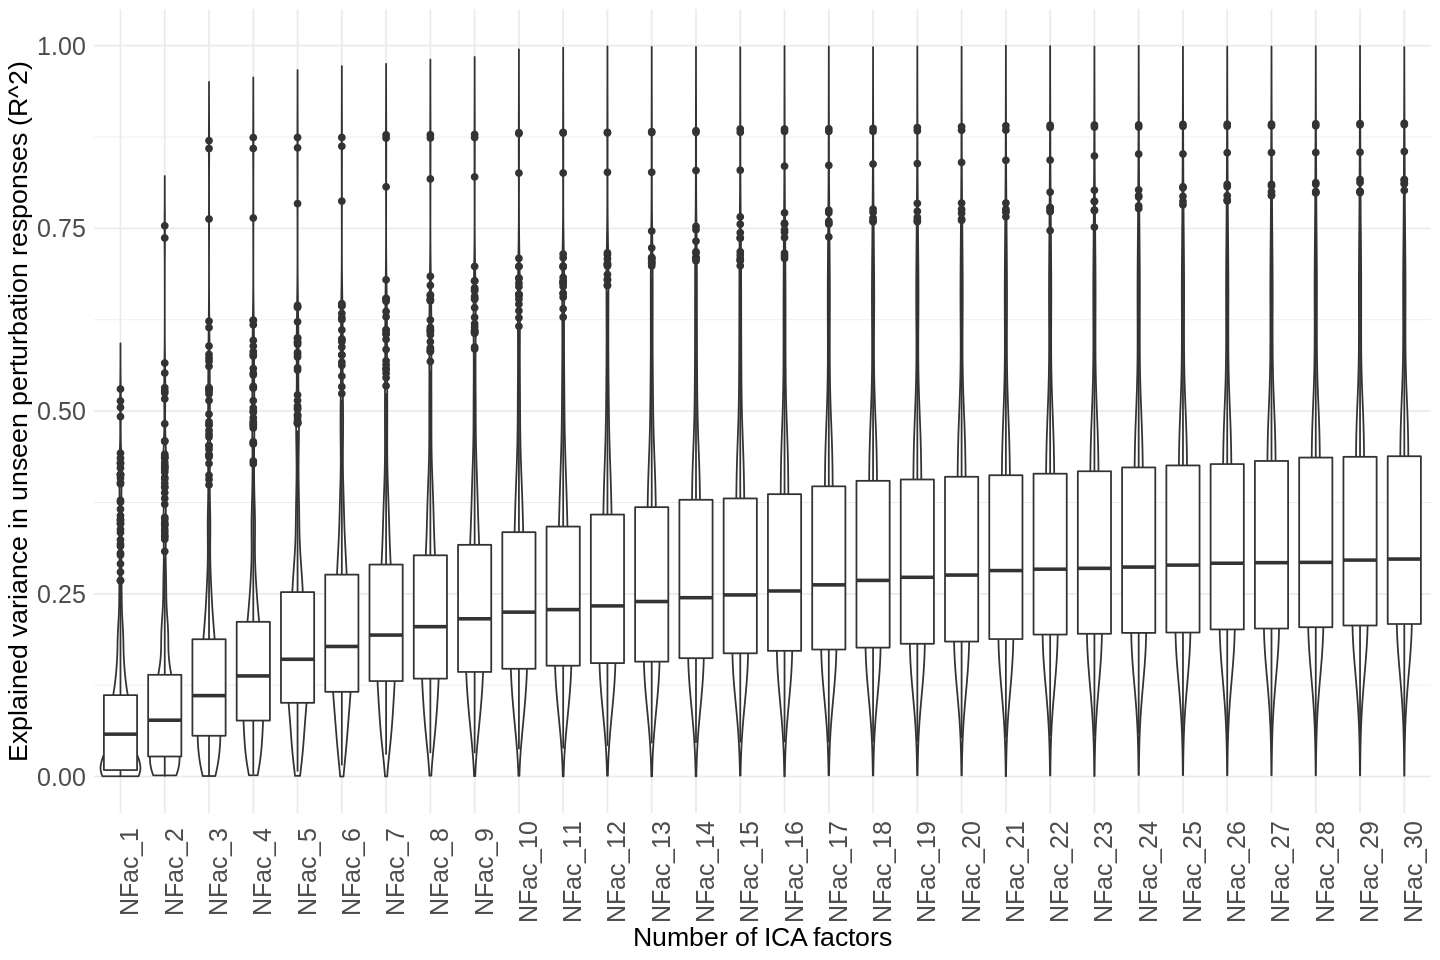

In [10]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(hh, aes(x=variable, y=value)) + 
     geom_violin(trim=FALSE)+
     geom_boxplot()+theme_minimal()+ 
     #stat_summary(fun.data = mean, geom = "text", size=6)+
        # stat_compare_means(method="t.test",paired = FALSE,
        #                         comparisons = list(c("Control", "KO")),
        #                         color="red", method.args = list(alternative = "less"),
        #                         label.y = c(30), aes(label = ..p.signif..))+
     #scale_fill_brewer(palette = "Pastel1")+
ylab("Explained variance in unseen perturbation responses (R^2)")+
theme(axis.text = element_text(size=15),
      axis.text.x = element_text(angle=90),
              axis.title =  element_text(size=16))+ylim(0,1) +xlab("Number of ICA factors") 

In [ ]:
myH <- t(k$S)
myW <- k$M

In [ ]:
dim(myH)

In [ ]:
dim(myW)

In [ ]:
rownames(myH) <- 1:nrow(myH)
colnames(myW) <- 1:ncol(myW)


In [ ]:
rownames(myW) <- KOGenes
colnames(myH) <- rownames(selCoefs)

In [ ]:
head(myW)

In [ ]:
head(myH)

In [ ]:
head(selCoefs)

In [ ]:
M_targets = cor(t(myH), method = "pearson")
M_genes = cor((myW), method = "pearson")

In [ ]:
boxplot(M_targets, main="M targets")
abline(h=0.2, col="red")
abline(h= -0.2, col="red")
axis(2, at = seq(-0.5,0.5,0.1))


In [ ]:
boxplot(M_genes, main="M genes")
abline(h=0.2, col="red")
abline(h= -0.2, col="red")
axis(2, at = seq(-0.5,0.5,0.1))

In [ ]:
M_targets[M_targets > 0.2] = 0.2
M_targets[M_targets < -0.2] = -0.2

M_genes[M_genes > 0.3] = 0.3
M_genes[M_genes < -0.3] = -0.3

In [ ]:
# diag(M_targets) <- NA
# diag(M_genes) <- NA

In [ ]:
#fviz_nbclust(M_targets, kmeans, method = "wss", k.max = 19)+ggtitle("Optimal number of clusters in of factor covariance based on target loadings")


In [ ]:
#fviz_nbclust(M_genes, kmeans, method = "wss", k.max = 19)+ggtitle("Optimal number of clusters in of factor covariance based on gene loadings")


In [ ]:
options(repr.plot.width=9, repr.plot.height=8)

col3 = colorRampPalette(c("navy", "white", "red"))(50)
corrplot::corrplot(M_genes, order = 'AOE', cl.lim=c(-0.3,0.3), col=col3, method = 'ellipse', is.corr = FALSE, tl.cex = 1.5, diag = FALSE, type = 'upper')

In [ ]:
# options(repr.plot.width=10, repr.plot.height=6)

# ctree=9
# plot(hmTarget$tree_row)
# abline(h=ctree, col="red", lty=2, lwd=2)


In [ ]:
options(repr.plot.width=9, repr.plot.height=8)

hmGene <- pheatmap(M_genes, clustering_method="ward.D2", show_colnames = TRUE, show_rownames = TRUE, 
                clustering_distance_rows="euclidean", clustering_distance_cols="euclidean",
                   main="Covariance matrix of factors based on effected gene loadings", colorRampPalette(c("navy", "white", "red"))(50))


In [ ]:
hmGene$tree_col$order


In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
plot(hmGene$tree_row)


In [ ]:
res.pca <- prcomp(M_targets, scale = FALSE)
summary(res.pca)
fviz_eig(res.pca, choice = 'variance', ncp = 19)+ggtitle("Scree plot of factor covariance based on target loadings")



In [ ]:
res.pca <- prcomp(M_genes, scale = FALSE)
fviz_eig(res.pca, ncp = 19)+ ggtitle("Scree plot of factor covariance based on effected gene loadings")


In [ ]:
head(selCoefs)

In [ ]:
boxplot(selCoefs)

In [ ]:
geneModulesN$GeneGroup <- paste0("GeneGroup_", geneModulesN$GeneGroup)

In [ ]:
unique(geneModulesN)

In [ ]:
guideModulesN$GuideGroup <- paste0("KOGroup_", guideModulesN$GuideGroup)

In [ ]:
unique(guideModulesN)

In [ ]:
guideModulesN$GuideColor <- NULL
geneModulesN$GeneColor <- NULL

In [ ]:
plotFactorHeatmap <- function(coefsAll, sKOGenes, sEffectGenes, elem){
  tempDF <- t(coefsAll[sEffectGenes, sKOGenes])
  #tmpPVals <- pValsAllAdj[sTargets, sGenes]
  #tempDF[tmpPVals > 0.1] <- 0
  tempDF[tempDF > 0.5] = 0.5
  tempDF[tempDF < -0.5] = -0.5
   
  annoCols<-list(GeneGroup=c(GeneGroup_0="#1B9E77", GeneGroup_1="#D95F02", GeneGroup_2="#7570B3", GeneGroup_3="#E7298A", 
                        GeneGroup_4="#66A61E", GeneGroup_5="#E6AB02", GeneGroup_6="#A6761D", GeneGroup_7="#666666"),
                 GuideGroup=c(KOGroup_0="#1f77b4", KOGroup_1="#ff7f0e", KOGroup_2="#279e68", KOGroup_3="#d62728", 
                        KOGroup_4="#aa40fc", KOGroup_5="#8c564b"))
    
    
  annotDFcol <- subset(geneModulesN, rownames(geneModulesN) %in% colnames(tempDF))
  annotDFrow <- subset(guideModulesN, rownames(guideModulesN) %in% rownames(tempDF))
    
  options(repr.plot.width=16, repr.plot.height=9)
  km2 <- pheatmap(tempDF, main = paste0("Factor ",elem),
           na_col = "grey",  
           annotation_col = annotDFcol,
                  annotation_row = annotDFrow,
            annotation_colors = annoCols,
           clustering_method="ward.D2",
           clustering_distance_rows="euclidean",
           clustering_distance_cols="euclidean", colorRampPalette(c("navy", "white", "red"))(50))
  
  geneOrder = colnames(tempDF)[km2$tree_col$order]
  koOrder = rownames(tempDF)[km2$tree_row$order]
    
  geneClusters=cutree(km2$tree_col, h=1)
  i=1
  while(length(unique(geneClusters)) > 2){
    i = (i+0.5)
    geneClusters <- cutree(km2$tree_col, h=i)
  }
  
    
  geneClusters_one <- names(geneClusters[geneClusters==1])
  geneClusters_two <- names(geneClusters[geneClusters==2])
    
    
  guideClusters=cutree(km2$tree_row, h=1)
  i=1
  while(length(unique(guideClusters)) > 2){
    i = (i+0.5)
    guideClusters <- cutree(km2$tree_row, h=i)
  }
  
  guideClusters_one <- names(guideClusters[guideClusters==1])
  guideClusters_two <- names(guideClusters[guideClusters==2])
    
  return(list("geneClusters_one"=geneClusters_one, "geneClusters_two"=geneClusters_two,
              "guideClusters_one"=guideClusters_one, "guideClusters_two"=guideClusters_two,
             "geneOrder" = geneOrder, "koOrder" = koOrder))
}


#ensemblBackground <- mapIds(org.Mm.eg.db, keys = colnames(coefsAll), keytype = "SYMBOL", column= "ENSEMBL")


In [ ]:
getOutliers <- function(x){
  qX <- quantile(x)
  IQR = qX[4] - qX[2]
  minLev = qX[2] - IQR
  maxLev = qX[4] + IQR
  
  return(x[ x < minLev | x > maxLev])
}


In [ ]:
getOutliers2 <- function(x){
  qX <- quantile(x)
  IQR = qX[4] - qX[2]
  minLev = qX[2] - 1.3*IQR
  maxLev = qX[4] + 1.3*IQR
  
  return(x[ x < minLev | x > maxLev])
}


In [ ]:
pathwayGenes <- list()
pathwayKOs <- list()
pathwayEffectedGenes <- list()
pathwayEffectedUpGenes <- list()
pathwayEffectedDownGenes <- list()
factorGeneGroups <- list()
geneKOOrder <- list()


for(elem in c(1:nFactors)){
  print(paste0("############## FACTOR : ",elem, " ##################"))
  
  factor0X <- myW[,elem]
  names(factor0X) <- rownames(myW)
  sKOGenes <- names(getOutliers(factor0X))
  print(length(sKOGenes))
    
  factor0Y <- myH[elem,]
  names(factor0Y) <- colnames(myH)
  sEffectGenes <- names(getOutliers2(factor0Y))
  print(length(sEffectGenes))
 
  boxplot(selCoefs)
  options(repr.plot.width=16, repr.plot.height=9)

  k <- plotFactorHeatmap(selCoefs, sKOGenes, sEffectGenes, elem)

  names(k) <- c(paste0("Factor ", elem, " gene group 1"), paste0("Factor ", elem, " gene group 2"),
                paste0("Factor ", elem, " guide group 1"),paste0("Factor ", elem, " guide group 2"),
                paste0("Factor ", elem, " gene order"), paste0("Factor ", elem, " guide order") )
  factorGeneGroups <- lappend(factorGeneGroups, k[1:4])
  geneKOOrder <- lappend(geneKOOrder, k[5:6])

  print("Genes in the pathway: ")
  pGenes = c(sEffectGenes, sKOGenes)

  pathwayGenes <- lappend(pathwayGenes, pGenes)
  pathwayKOs <- lappend(pathwayKOs, sKOGenes)
  pathwayEffectedGenes <- lappend(pathwayEffectedGenes, sEffectGenes)
  
  #getDAVIDGOTerms (pGenes, ensemblBackground, fNamePrefix=paste0("NMF_",inT, "_", elem), titleStr=paste0("Factor ",elem,))

}


In [ ]:
length(unique(unlist(pathwayKOs)))

In [ ]:
sort(unique(unlist(pathwayKOs)))

In [ ]:

length(unique(unlist(pathwayEffectedGenes)))

In [ ]:
saveRDS(geneKOOrder, paste0("/home/beraslan/jovian-work/analysisSingle/R/factorGeneGroups.rds"))

In [ ]:
KOFactorMatrix = data.frame(matrix(0, ncol = length(unique(unlist(pathwayKOs))), nrow= nFactors))
rownames(KOFactorMatrix) <- paste0("Factor ", 1:nrow(KOFactorMatrix))
colnames(KOFactorMatrix) <- sort(unique(unlist(pathwayKOs)))

In [ ]:
for(i in 1:length(pathwayKOs)){
    facKOGenes = pathwayKOs[[i]]
    KOFactorMatrix[i,facKOGenes] = 1
}

In [ ]:
head(KOFactorMatrix)

In [ ]:
options(repr.plot.width=26, repr.plot.height=6)

pheatmap(KOFactorMatrix, color = c("white","blue"), cluster_rows = F, main = "KO genes per factor")

In [ ]:
EGenesFactorMatrix = data.frame(matrix(0, ncol = length(unique(unlist(pathwayEffectedGenes))), nrow= nFactors))
rownames(EGenesFactorMatrix) <- paste0("Factor ", 1:nrow(EGenesFactorMatrix))
colnames(EGenesFactorMatrix) <- sort(unique(unlist(pathwayEffectedGenes)))

In [ ]:
for(i in 1:length(pathwayEffectedGenes)){
    facEffectedGenes = pathwayEffectedGenes[[i]]
    EGenesFactorMatrix[i,facEffectedGenes] = 1
}

In [ ]:
options(repr.plot.width=26, repr.plot.height=6)

pheatmap(EGenesFactorMatrix, color = c("white","red"), cluster_rows = F, main = "Effected genes per factor")

In [ ]:
names(pathwayGenes) <- paste0("Factor_",1:nFactors)
names(pathwayTargets) <- paste0("Factor_",1:nFactors)
names(pathwayEffectedGenes) <-  paste0("Factor_",1:nFactors)


In [ ]:
factorGeneGroups <- unlist(factorGeneGroups, recursive = F)
lLen <- unlist(lapply(factorGeneGroups, length))
factorGeneGroups <- factorGeneGroups[lLen!=0]

In [ ]:
writePathwayFile(pathwayGenes=factorGeneGroups,
                 fileName="/home/beraslan/jovian-work/analysisSingle/ICA_15_factors_effectedGenes.csv",
                 cNames= names(factorGeneGroups))

In [ ]:
length(factorGeneGroups)